## Ejercicio Banco Lime Shap

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report
import lime 
import shap
from lime import lime_tabular
import plotly.express as px
import plotly.graph_objects as go

In [21]:
def saca_metricas(y1, y2): # Función para sacar todas las métricas necesarias para la evaluación y plotearla la curav ROC
    print('Matriz de Confusión')
    print(confusion_matrix(y1, y2)) 
    print('Accuracy:', accuracy_score(y1, y2))
    print('Precision:', precision_score(y1, y2))
    print('Recall:', recall_score(y1, y2))
    print('F1 Score:', f1_score(y1, y2))
    
    # Cálculo de la curva ROC y AUC
    false_positive_rate, recall, _ = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC:', roc_auc)
    
    # Crear gráfico interactivo con Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=false_positive_rate, y=recall, mode='lines', name='Curva ROC', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Línea base', line=dict(color='red', dash='dash')))
    
    fig.update_layout(
        title=f'Curva ROC (AUC = {roc_auc:.2f})',
        xaxis_title='False Positive Rate',
        yaxis_title='Recall',
        template='plotly_white'
    )
    
    fig.show()

In [22]:
df_bank = pd.read_csv('bank-full.csv',sep=';')

In [23]:
categorical_feature = df_bank.select_dtypes(include='object').columns
numerical_feature = df_bank.select_dtypes(exclude='object').columns

In [24]:
for i in categorical_feature:
    le = LabelEncoder()
    df_bank[i] = le.fit_transform(df_bank[i])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df_bank.drop('y',axis=1),
                                                    df_bank['y'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_bank['y'])

In [26]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [27]:
model1 = RandomForestClassifier(random_state=42)
model1.fit(X_train,y_train)
y_pred = model1.predict(X_test)

In [28]:
saca_metricas(y_test,y_pred)

Matriz de Confusión
[[7755  230]
 [ 617  441]]
Accuracy: 0.9063363927900033
Precision: 0.6572280178837556
Recall: 0.4168241965973535
F1 Score: 0.5101214574898786
AUC: 0.6940100945416323


### Explicabilidad: lime

La biblioteca LIME (Local Interpretable Model-agnostic Explanations) sirve para explicar las predicciones de modelos de machine learning de manera interpretable para los humanos.

En pocas palabras:

* LIME analiza una predicción específica de cualquier modelo (es agnóstica al tipo de modelo).
* Genera explicaciones locales, mostrando qué características influyeron más en esa predicción.
* Es útil para entender modelos complejos como Random Forest, XGBoost o redes neuronales, que normalmente son “cajas negras”.

In [29]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, # Este objeto nos ayuda a explicar el modelo
                                                   feature_names = X_train.columns,
                                                   mode= 'classification',
                                                   training_labels = y_train,
                                                   random_state=42)

In [30]:
X_test.iloc[7] # Seleccionamos el cliente 8 de X_test

age           64
job            5
marital        0
education      0
default        0
balance      109
housing        0
loan           0
contact        0
day           23
month          6
duration     706
campaign       1
pdays        225
previous       2
poutcome       2
Name: 43965, dtype: int64

C:\Users\pauri\AppData\Roaming\Python\Python313\site-packages\lime\discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\pauri\AppData\Roaming\Python\Python313\site-packages\lime\discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

C:\Users\pauri\AppData\Roaming\Python\Python313\site-packages\lime\lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\pauri\AppData\Roaming\Py

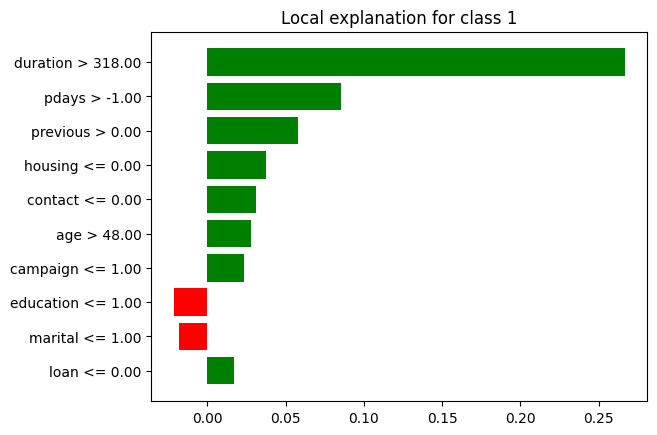

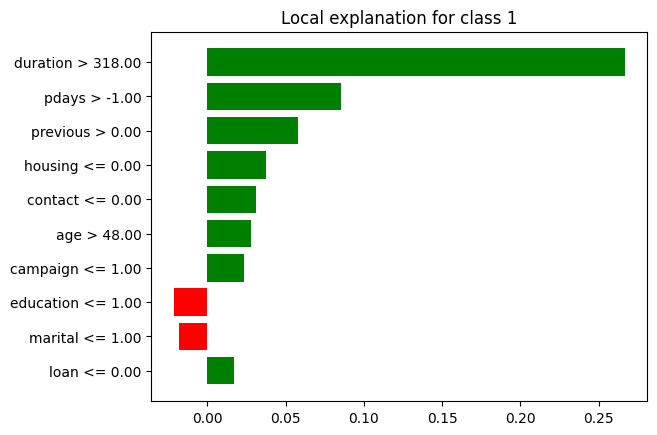

In [ ]:
exp = explainer.explain_instance(X_test.iloc[7],model1.predict_proba)
# exp.show_in_notebook(show_all=False) ## Este se usa en jupyter notebook

# Para VSC
# Guardar explicación como HTML
exp.save_to_file("lime_explanation.html") # Podemos abrir este fichero y ver la explicabilidad

# O visualizar con matplotlib
exp.as_pyplot_figure()

### Explicabilidad: Shap

SHAP (SHapley Additive exPlanations) es otra biblioteca para explicar modelos de machine learning, similar a LIME, pero con un enfoque basado en teoría de juegos.

En pocas palabras:
* SHAP asigna a cada característica un valor de contribución a la predicción de un modelo.
* Es model-agnostic, pero también tiene optimizaciones para modelos específicos como XGBoost, LightGBM o scikit-learn.
* Genera explicaciones locales (para una predicción) y globales (para todo el modelo).
* Sus gráficos (summary_plot, dependence_plot) permiten ver fácilmente qué variables influyen más y cómo afectan las predicciones.

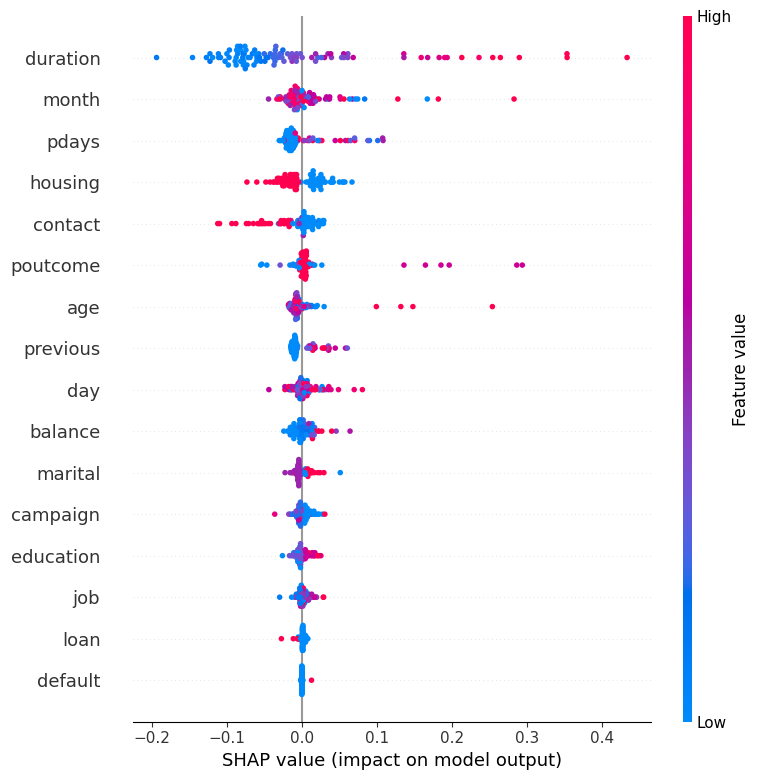

In [33]:
explainer = shap.Explainer(model1)
shap_values = explainer.shap_values(X_test.iloc[0:100])
shap.summary_plot(shap_values[:,:,1],X_test.iloc[0:100])